# Restricted spectral approximation experiment (Section 5.1)

The script exhaustively compares different coarsening schemes with respect to their ability to preserve the action of the combinatorial Laplacian matrix $L$ for every vector $ x \in U_K$, where the latter is the principal eigenspace of size $K$.

The code accompanies the preprint: [Graph reduction with spectral and cut guarantees](https://arxiv.org/abs/1808.10650). The final version of the paper will appear at JMLR.

Depedencies: pygsp, matplotlib, numpy, scipy, networkx, sortedcontainers

This work was kindly supported by the Swiss National Science Foundation (grant number PZ00P2 179981).

15 March 2019

[Andreas Loukas](https://andreasloukas.wordpress.com)

Released under the MIT license 


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from graph_coarsening.coarsening_utils import *
import graph_coarsening.graph_lib as graph_lib
import graph_coarsening.graph_utils as graph_utils

import numpy as np
import scipy as sp
from scipy import io
from scipy.linalg import circulant
import time
import os 

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import pygsp as gsp
gsp.plotting.BACKEND = 'matplotlib'

In [4]:
# Parameters
graphs  = ['yeast','minnesota', 'bunny', 'airfoil'] 
methods = ['heavy_edge', 'variation_edges', 'variation_neighborhoods', 'algebraic_JC', 'affinity_GS', 'kron'] 
K_all   = np.array([10,40], dtype=np.int32)  
r_all   = np.linspace(0.1, 0.9, 17, dtype=np.float32) 

print('k: ', K_all, '\nr: ', r_all)

k:  [10 40] 
r:  [0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9 ]


### The actual experiment code (this will take long)
If one needs to just see the results, skip running this part.

In [5]:
rerun_all = False
rewrite_results = False
if rerun_all:
    
    algorithm  = 'greedy'  
    max_levels = 20
    n_methods  = len(methods)
    n_graphs   = len(graphs)

    for graphIdx, graph in enumerate(graphs):

        N = 4000 # this is only an upper bound (the actual size depends on the graph)    
        G = graph_lib.real(N, graph)     
        N = G.N
        if N<100: continue

        # precompute spectrum needed for metrics
        if K_all[-1] > N/2:
            [Uk,lk] = eig(G.L)             
        else:
            offset = 2*max(G.dw)
            T = offset*sp.sparse.eye(G.N, format='csc') - G.L
            lk, Uk = sp.sparse.linalg.eigsh(T, k=K_all[-1], which='LM', tol=1e-6)
            lk = (offset-lk)[::-1]
            Uk = Uk[:,::-1]                

        subspace   = np.zeros((n_methods, len(K_all), len(r_all))) 
        failed     = np.zeros((n_methods, len(K_all), len(r_all)))
        ratio      = np.zeros((n_methods, len(K_all), len(r_all)))

        for KIdx, K in enumerate(K_all):

            print('{} {}| K:{:2.0f}'.format(graph, N, K))

            for rIdx,r in enumerate(r_all):     

                n_target = int(np.floor(N*(1-r)))
                if K > n_target:
                    print('Warning: K={}>n_target={}. skipping'.format(K, n_target))
                    continue # K = n_target

                for methodIdx,method in enumerate(methods):

                    # algorithm is not deterministic: run a few times
                    if method == 'kron':
                        if KIdx == 0:
                            n_iterations = 2
                            n_failed = 0
                            r_min = 1.0
                            for iteration in range(n_iterations):

                                Gc, iG  = kron_coarsening(G, r=r, m=None)
                                metrics = kron_quality(iG, Gc, kmax=K_all[-1], Uk=Uk[:,:K_all[-1]], lk=lk[:K_all[-1]])

                                if metrics['failed']: n_failed += 1
                                else:
                                    r_min = min(r_min, metrics['r'])
                                    for iKIdx, iK in enumerate(K_all):
                                        subspace[  methodIdx, iKIdx, rIdx] += metrics['error_subspace'][iK-1]

                            subspace[  methodIdx, :, rIdx] /= (n_iterations-n_failed)
                            failed[    methodIdx, :, rIdx]  = 1 if (r_min < r - 0.05) else 0
                            ratio[     methodIdx, :, rIdx]  = r_min

                            if np.abs(r_min - r) > 0.02: print('Warning: ratio={} instead of {} for {}'.format(r_min, r, method))

                    else:
                        C, Gc, Call, Gall = coarsen(G, K=K, r=r, max_levels=max_levels, method=method, algorithm=algorithm, Uk=Uk[:,:K], lk=lk[:K])
                        metrics = coarsening_quality(G, C, kmax=K, Uk=Uk[:,:K], lk=lk[:K])

                        subspace[  methodIdx, KIdx, rIdx] = metrics['error_subspace'][-1]
                        failed[methodIdx, KIdx, rIdx] = 1 if (metrics['r'] < r - 0.05) else 0
                        ratio[methodIdx, KIdx, rIdx]  = metrics['r']

                        if np.abs(metrics['r'] - r) > 0.02: 
                            print('Warning: ratio={} instead of {} for {}'.format(metrics['r'], r, method))

        if rewrite_results:
            filepath = os.path.join('..', 'results', 'experiment_approximation_'+ graph +'.npz')
            print('.. saving to "' + filepath + '"')
            np.savez(filepath, methods=methods, K_all=K_all, r_all=r_all, subspace=subspace, failed=failed)

print('done!') 

yeast 1458| K:10
Failed to find a square root.
yeast 1458| K:40
minnesota 2642| K:10
minnesota 2642| K:40
bunny 2503| K:10
Failed to find a square root.
bunny 2503| K:40
airfoil 4000| K:10
airfoil 4000| K:40
done!


### Figure 2 of the paper
Plot $\epsilon$ as a function of $r$ for a few different graphs (for $K=10,40$) 

The figures are drawn in the following in order:
* experiment_approximation_yeast_K=10
* experiment_approximation_airfoil_K=10
* experiment_approximation_minnesota_K=10
* experiment_approximation_bunny_K=10
* experiment_approximation_yeast_K=40
* experiment_approximation_airfoil_K=40
* experiment_approximation_minnesota_K=40
* experiment_approximation_bunny_K=40


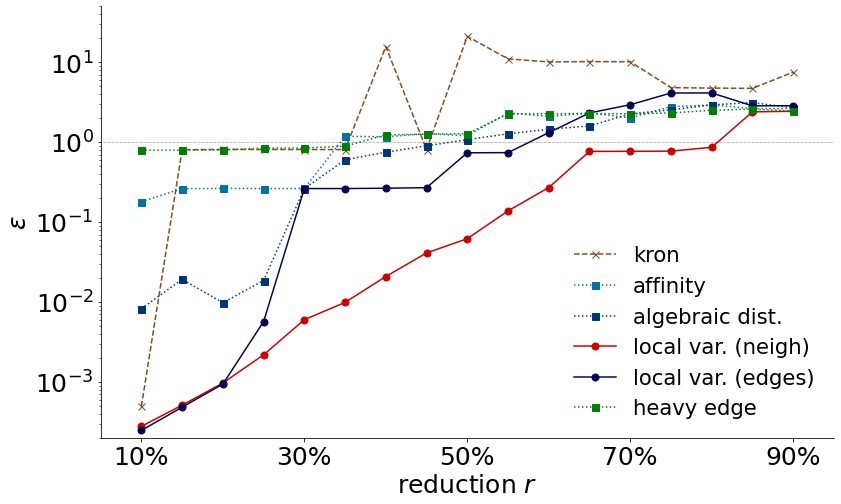

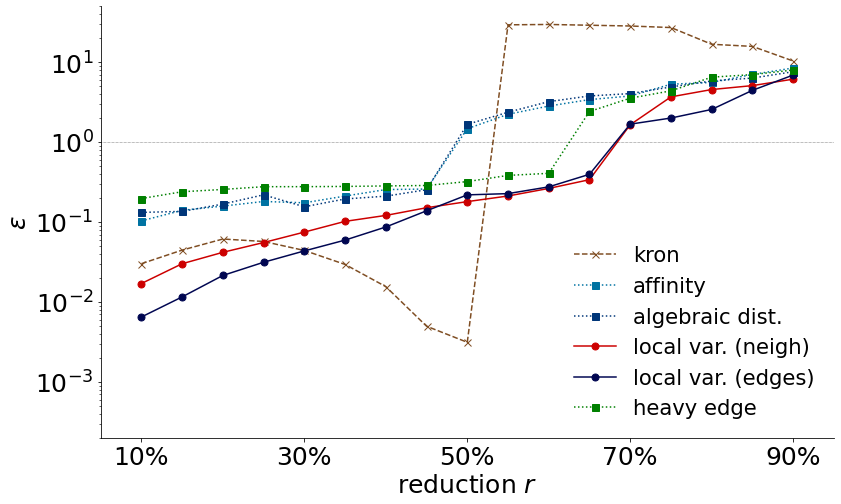

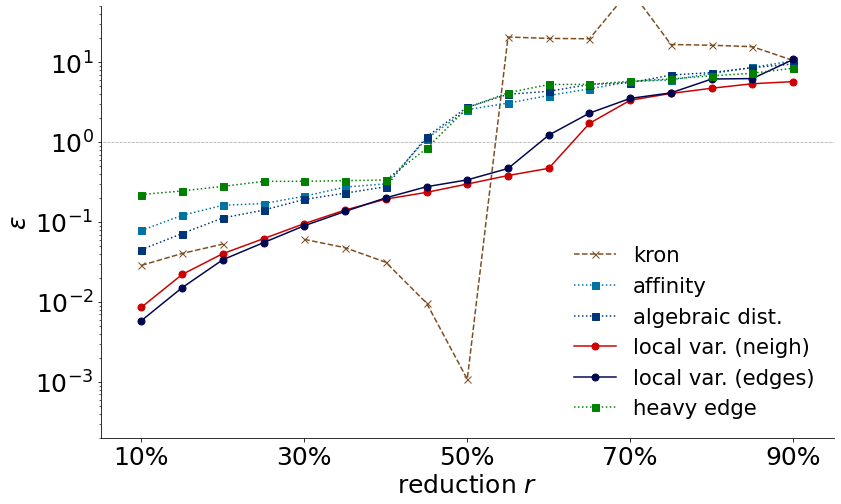

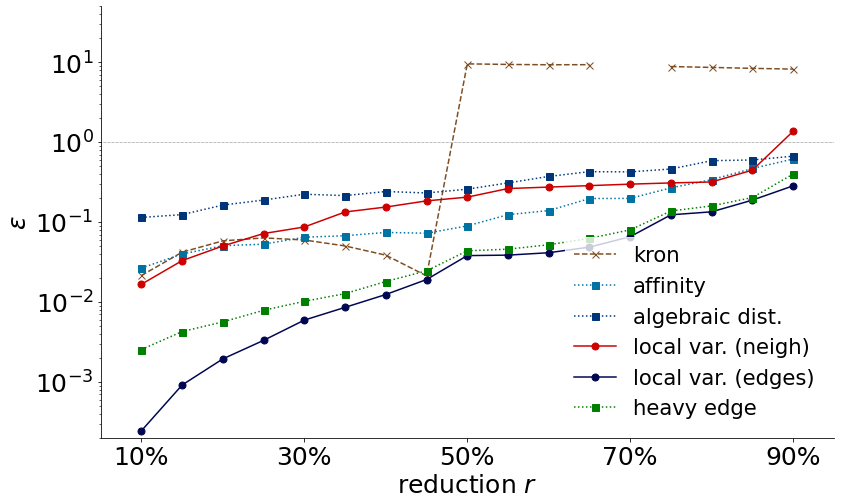

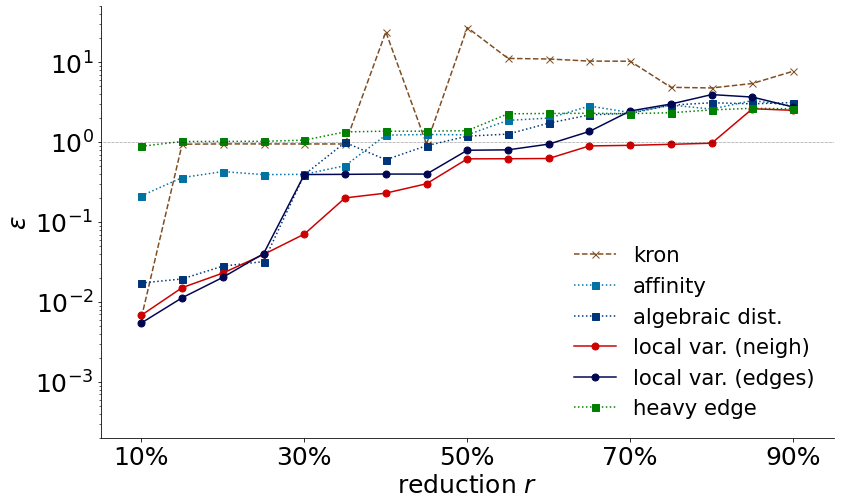

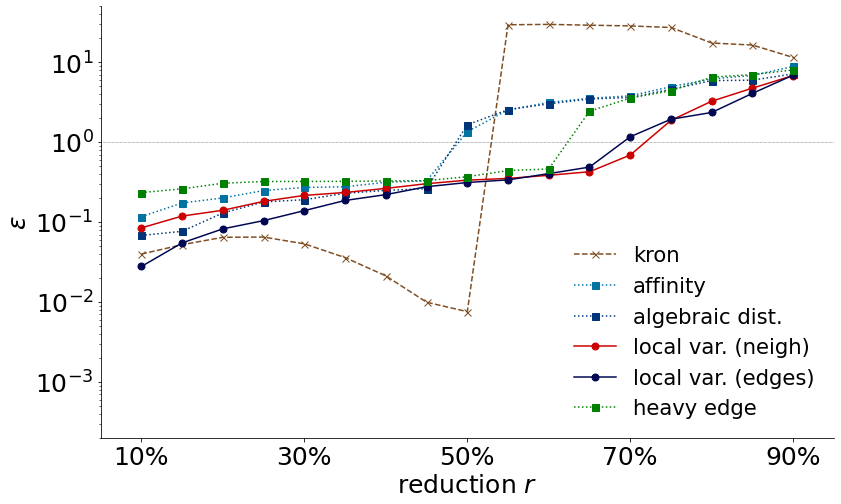

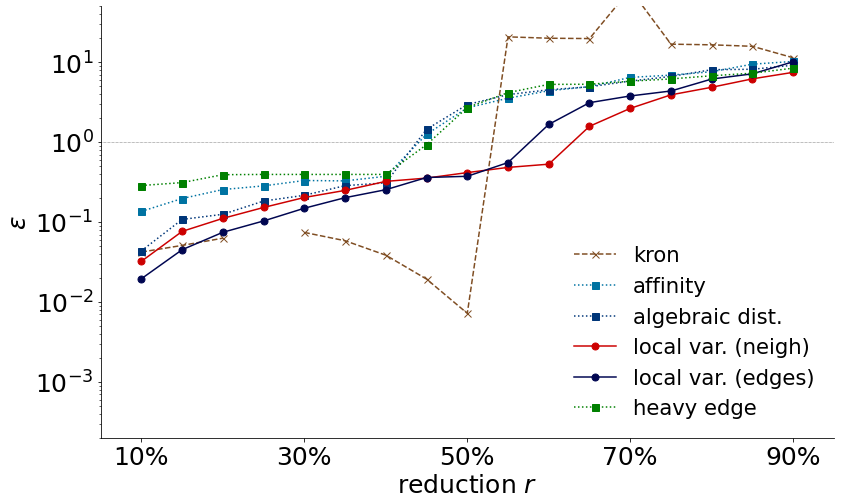

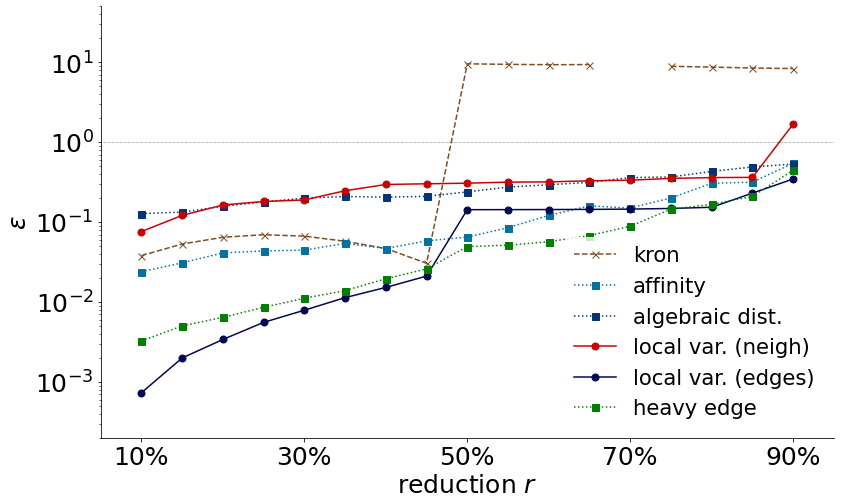

In [6]:
matplotlib.rcParams.update({'font.size': 25})

from matplotlib import cm
colors = [ cm.ocean(x) for x in np.linspace(0, 0.95, len(methods)+1) ]
colors[1] = [0.8,0,0] 
colors[-2] = (np.array([127, 77, 34])/255).tolist() 

size = 2.7*2.8; 

graphs  = ['yeast','airfoil', 'minnesota', 'bunny'] 
n_graphs = len(graphs)

print('The figures are drawn in the following in order:')
for KIdx in [0,1]:         
    for graphIdx, graph in enumerate(graphs):

        # load results
        filepath = os.path.join('..', 'results', 'experiment_approximation_'+ graph +'.npz')
        data = np.load(filepath)
        methods, K_all, r_all, subspace, failed = data['methods'], data['K_all'], data['r_all'], data['subspace'], data['failed']

        K = K_all[KIdx]

        fig, axes = plt.subplots(1, 1, figsize=(1.618*size, size)); # 1/1.618

        for methodIdx,method in reversed(list(enumerate(methods))):

            lineWidth = 1.5; marker = 's'
            method = method.replace('_', ' ')                
            if method == 'heavy edge':
                method = 'heavy edge'
                cIdx, line, marker = 0, ':', 's'
            elif 'variation edges' in method:
                method = 'local var. (edges)'
                cIdx, line, marker, lineWidth = 2, '-', 'o', 1.5
            elif (method == 'variation neighborhoods') or (method == 'variation neighborhood'):
                method = 'local var. (neigh)'
                cIdx, line, marker, lineWidth = 1, '-', 'o', 1.5 
            elif 'algebraic' in method:
                method = 'algebraic dist.'
                cIdx, line = 3, ':'
            elif 'affinity' in method:
                method = 'affinity'
                cIdx, line = 4, ':'
            elif method == 'kron':
                method = 'kron'
                cIdx, line, marker = 5, '--', 'x'
            else:
                continue

            style = line + marker 
            color = colors[cIdx]

            tmp = subspace[methodIdx,KIdx,:]
            tmp[tmp==0] = np.NaN                      # requested k was larger than n_target
            tmp[failed[methodIdx,KIdx,:]==1] = np.NaN # there was a failure to reach the given ratio

            axes.plot(r_all, tmp, style, label='{}'.format(method), color=color, lineWidth=lineWidth, markersize=7)

        axes.set_xlabel('reduction $r$')
        axes.set_ylabel('$\epsilon$')

        loc, lab = [0.1,0.3,0.5,0.7,0.9],  []
        for i,iloc in enumerate(loc): lab.append(matplotlib.text.Text(0,0,'{:2d}%'.format(int(iloc*100))))
        plt.xticks(loc, lab)

        axes.set_yscale('log')
        if K == 10:
            axes.set_ylim([0.0002, 50])
        else:
            axes.set_ylim([0.0002, 50])
        axes.set_xlim([0.05, .95])

        legend0 = axes.legend(fontsize=21.2, loc='lower right', edgecolor=[1,1,1])
        axes.plot([0.05, 0.95], [1,1],  'k:', lineWidth=0.5)
        axes.spines['right'].set_visible(False)
        axes.spines['top'].set_visible(False)
        fig.tight_layout()
        
        print('* experiment_approximation_'+ graph + '_K=' + str(K))
        filepath = os.path.join('..', 'results', 'experiment_approximation_'+ graph + '_K=' + str(K) + '.pdf')
#         fig.savefig(filepath)